In [1]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
import pandas as pd
from nltk.corpus import stopwords
import re
import json
STOPWORDS = set(stopwords.words('english'))
import os

Using TensorFlow backend.


# Data pre-processing

In [2]:
embedding_dim=100
oov_token = '<OOV>'
train_test_split = 0.8
max_len = 200
trunc_type = 'post'
padding_type = 'post'

In [3]:
df = pd.read_csv('./data/bbc-text.csv')
labels = df.get('category').values.tolist()
articles = df.get('text').values.tolist()
for i in range(len(articles)):
    for word in STOPWORDS:
        token = ' '+word+' '
        articles[i] = articles[i].replace(token,' ')
        articles[i] = re.sub(r'\s+', ' ',articles[i])

In [7]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(articles)
sequences = tokenizer.texts_to_sequences(articles)
article_sequences = pad_sequences(sequences,maxlen=max_len,truncating=trunc_type,padding=padding_type)
word_index = tokenizer.word_index
vocab_size = len(word_index)

split_index = int(len(article_sequences)*train_test_split)
train_sequences = np.array(article_sequences[0:split_index])
test_sequences = np.array(article_sequences[split_index:])

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_sequences = label_tokenizer.texts_to_sequences(labels)
train_label = np.array(label_sequences[0:split_index])
test_label = np.array(label_sequences[split_index:])

In [8]:
tokenizer_json = tokenizer.to_json()
label_tokenizer_json = label_tokenizer.to_json()

In [9]:
embeddings_index = {};
with open('glove/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [10]:
if not os.path.exists('tokenizer.json'):
    with open('tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
if not os.path.exists('label_tokenizer_json.json'):
    with open('label_tokenizer_json.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(label_tokenizer_json, ensure_ascii=False))    

In [11]:
print(train_sequences.shape)
print(train_label.shape)
print(test_sequences.shape)
print(test_label.shape)

(1780, 200)
(1780, 1)
(445, 200)
(445, 1)


In [12]:
np.save('train_sequences.npy',train_sequences)
np.save('train_label.npy',train_label)
np.save('test_sequences.npy',test_sequences)
np.save('test_label.npy',test_label)
np.save('embeddings_matrix.npy',embeddings_matrix)

In [13]:
print(vocab_size)
print(word_index['i'])

29699
3229


# Train the network

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, LSTM, Embedding,Conv2D,Bidirectional,MaxPool2D,Reshape
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
from keras.callbacks import ModelCheckpoint
import json
import os
import datetime as dt
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
with open('tokenizer.json', 'r', encoding='utf-8') as f1:
    tokenizer_config = json.load(f1)
with open('label_tokenizer_json.json', 'r', encoding='utf-8') as f2:
    label_tokenizer_config = json.load(f2)

In [3]:
tokenizer = tokenizer_from_json(tokenizer_config)
label_tokenizer = tokenizer_from_json(label_tokenizer_config)

In [4]:
train_sequences= np.load('train_sequences.npy')
train_label= np.load('train_label.npy')
test_sequences = np.load('test_sequences.npy')
test_label= np.load('test_label.npy')
embeddings_matrix= np.load('embeddings_matrix.npy')

In [5]:
embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = len(word_index)
max_len = 200
rnn_units = 100

In [6]:
print(train_sequences.shape)
print(train_label.shape)
print(test_sequences.shape)
print(test_label.shape)

(1780, 200)
(1780, 1)
(445, 200)
(445, 1)


In [24]:
model = Sequential()
model.add(Embedding(vocab_size+1,embedding_dim,input_length=max_len,weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(rnn_units,return_sequences=True),merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Reshape((-1,rnn_units,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          2970000   
_________________________________________________________________
dropout_15 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 100)          160800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 200, 100, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 198, 98, 64)       640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 49, 64)       

In [25]:
epochs = 10
save_dir = './saved_model'
save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
callbacks = [ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 36s 20ms/step - loss: 1.6024 - accuracy: 0.7062 - val_loss: 0.2593 - val_accuracy: 0.9056
Epoch 2/10
1780/1780 [==============================] - 37s 21ms/step - loss: 0.2123 - accuracy: 0.9258 - val_loss: 0.1305 - val_accuracy: 0.9573
Epoch 3/10
1780/1780 [==============================] - 38s 22ms/step - loss: 0.1337 - accuracy: 0.9590 - val_loss: 0.1111 - val_accuracy: 0.9596
Epoch 4/10
1780/1780 [==============================] - 39s 22ms/step - loss: 0.0737 - accuracy: 0.9775 - val_loss: 0.0737 - val_accuracy: 0.9730
Epoch 5/10
1780/1780 [==============================] - 39s 22ms/step - loss: 0.0618 - accuracy: 0.9837 - val_loss: 0.0865 - val_accuracy: 0.9640
Epoch 6/10
1780/1780 [==============================] - 39s 22ms/step - loss: 0.0599 - accuracy: 0.9775 - val_loss: 0.1078 - val_accuracy: 0.9618
Epoch 7/10
1780/1780 [==============================] - 38s 21ms/step - loss:

In [26]:
model.evaluate(test_sequences,test_label)

445/445 [==============================] - 2s 4ms/step


[0.06769250205226159, 0.9775280952453613]

In [57]:
result = np.argmax(model.predict(test_sequences[2][None,:]))

In [58]:
label_tokenizer.sequences_to_texts([[result]])

['politics']

In [65]:
tokenizer.sequences_to_texts([train_sequences[2].tolist()])

['tigers wary farrell gamble leicester say rushed making bid andy farrell great britain rugby league captain decide switch codes anybody else involved process still way away going next stage tigers boss john wells told bbc radio leicester moment still lot unknowns andy farrell least medical situation whoever take going take big big gamble farrell persistent knee problems operation knee five weeks ago expected another three months leicester saracens believed head list rugby union clubs interested signing farrell decides move 15 man game move across union wells believes would better playing backs least initially sure could make step league union involved centre said wells think england would prefer progress position back row make use of rugby league skills within forwards jury whether cross divide club balance struck cost gamble option bringing ready made replacement <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <O

# Plot Training Process

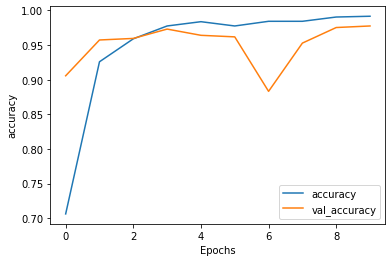

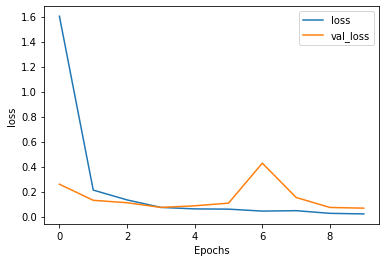

In [54]:
history = model.history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

# Load Model

In [18]:
from keras.models import load_model
import numpy as np
import json
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences

In [19]:
model = load_model('./saved_model/20122019-235909-e10.h5')

In [20]:
with open('tokenizer.json', 'r', encoding='utf-8') as f1:
    tokenizer_config = json.load(f1)
with open('label_tokenizer_json.json', 'r', encoding='utf-8') as f2:
    label_tokenizer_config = json.load(f2)
tokenizer = tokenizer_from_json(tokenizer_config)
label_tokenizer = tokenizer_from_json(label_tokenizer_config)

In [21]:
test_sequences = np.load('test_sequences.npy')
test_label= np.load('test_label.npy')

In [22]:
model.evaluate(test_sequences,test_label)

445/445 [==============================] - 2s 4ms/step


[0.06769250205226159, 0.9775280952453613]

In [102]:
text = 'lord of ring'
trunc_type = 'post'
padding_type = 'post'
max_len = 200
seq = np.array(pad_sequences(tokenizer.texts_to_sequences([text]),truncating=trunc_type,padding=padding_type,maxlen=max_len))

In [103]:
seq

array([[ 278, 1442, 4275,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [104]:
result = np.argmax(model.predict(seq),axis=1)[:,None].tolist()

In [105]:
result

[[5]]

In [106]:
print(label_tokenizer.sequences_to_texts(result))

['entertainment']
